In [1]:
# import relevant packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from acquire import get_crime_data
from datetime import datetime
import prepare
import seaborn as sns
from wrangle import *
from explore import *

In [2]:
# plotting defaults
plt.rc('figure', figsize=(23, 10))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

In [3]:
df = get_crime_data(use_cache = False)

Acquiring data from api


In [4]:
df = wrangle_crime_data(drop_cleared_by_exception=True)

Using cached csv


In [5]:
df.crime_type.count()

348063

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348063 entries, 36353 to 438346
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   crime_type        348063 non-null  object         
 1   family_violence   348063 non-null  object         
 2   occurrence_time   348063 non-null  datetime64[ns] 
 3   occurrence_date   348063 non-null  datetime64[ns] 
 4   report_time       348063 non-null  datetime64[ns] 
 5   report_date       348063 non-null  datetime64[ns] 
 6   location_type     348063 non-null  object         
 7   address           348063 non-null  object         
 8   zip_code          348063 non-null  float64        
 9   council_district  348063 non-null  float64        
 10  sector            348063 non-null  object         
 11  district          348063 non-null  object         
 12  latitude          348063 non-null  float64        
 13  longitude         348063 non-null  float

In [7]:
#Assign my .shp file to a variable named “asutin_map”
#austin_map = gpd.read_file('Boundaries_zipcode/geo_export_9b5aa23d-57b1-41f4-b4f9-0a9d97fac540.shp')

In [8]:
#austin_map = austin_map.drop(columns =['affgeoid10','geoid10','aland10','awater10'])

In [9]:
#austin_map = austin_map.rename(columns ={'zcta5ce10': 'zip_code'})

In [10]:
#austin_map = austin_map.astype({"zip_code": float}, errors='raise') 

In [11]:
#create a new dataframe with both our geographical and statistical data in it by merging our two tables together.
#new_df = austin_map.merge(df, on ='zip_code')

In [12]:
#new_df.to_csv('Geo_Crime_Reports.csv')

In [13]:
#new_df.info()

In [14]:
#new_df.head()

In [15]:
#Crime_type by zip_code
#fig, ax = plt.subplots(1, figsize=(8, 8))
#plt.xticks(rotation=90)
#new_df.plot(column="crime_type", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")
#bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=120))
#bar_info._A = []
#cbar = fig.colorbar(bar_info)

# We predict that there is a relationship between higher seasonal levels of crime and clearance status.

In [16]:
train, validate, test = prepare.split_data(df)

In [17]:
train.shape

(194915, 18)

In [18]:
train2 = train.copy()

In [19]:
#df['occurrence_date']= pd.to_datetime(df['occurrence_date'])
train2 = train2.set_index('occurrence_time').sort_index()

In [20]:
#Split by month first
train2['month'] = train2.index.month_name()
train2['weekdays'] = train2.index.day_name()
train2['year'] = train2.index.year

In [21]:
#train2.groupby(train2.occurrence_date.dt.month).crime_type.count().idxmax()

In [22]:
y = train2.groupby(['weekdays','year'])['crime_type'].count()

In [23]:
y

weekdays   year
Friday     2018    7516
           2019    8061
           2020    7469
           2021    6647
Monday     2018    7131
           2019    7489
           2020    7181
           2021    6223
Saturday   2018    7335
           2019    7540
           2020    6860
           2021    6207
Sunday     2018    7024
           2019    7517
           2020    6874
           2021    6110
Thursday   2018    7104
           2019    7158
           2020    7123
           2021    6002
Tuesday    2018    6836
           2019    7353
           2020    7019
           2021    5896
Wednesday  2018    6902
           2019    7162
           2020    7202
           2021    5974
Name: crime_type, dtype: int64

In [24]:
y_max = train2.groupby(['weekdays','year'])['crime_type'].count().max()

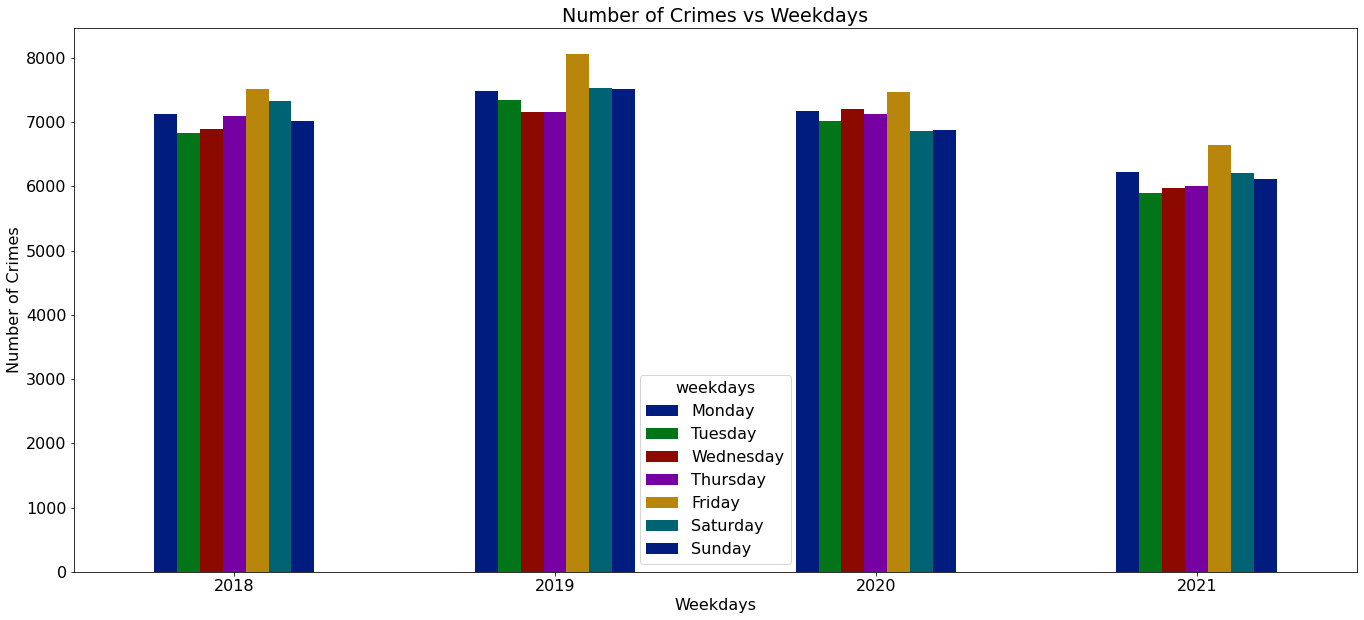

In [46]:
#Take a look at all the crime types
train2['weekdays'] = pd.Categorical(train2['weekdays'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
#overall_mean = df.groupby('month').crime_type.value_counts()
#Assuming 0 = Sunday, 1 = Monday, 2 = Tuesday, 3 = Wednesday, 4 = Thursday, 5 = Friday, 6 =Saturday
train2.groupby(['weekdays','year'])['crime_type'].count().unstack(0).plot.bar()
#sns.barplot(x=None, y = y, data = y, ci = None)
plt.title("Number of Crimes vs Weekdays")
plt.xlabel("Weekdays")
plt.ylabel("Number of Crimes")
plt.tick_params('x', rotation=360)
#plt.axhline(overall_mean,color="r")
None

In [26]:
friday_only = ['Friday']

In [27]:
subset_friday = train2.copy()

In [28]:
subset_friday = subset_friday[subset_friday.weekdays.isin(friday_only)]#With just friday only

In [29]:
subset_not_friday = train2.copy()

In [30]:
subset_not_friday = subset_not_friday[~subset_not_friday.weekdays.isin(friday_only)]#Without friday

### Stats Test

We'll be testing the following hypothesis:

$H_0$: There is no difference in crime levels between Fridays and other days of the week.
<br>
$H_a$: There is difference in crime levels between Fridays and other days of the week.

In [31]:
#Do 1 sample t-test compare friday vs the rest
#Need to subset the data just friday only and other exclude the friday and do 1 sample ttest
t_test_ind(subset_not_friday.cleared, subset_friday.cleared)

The t value between the two samples is 1.467 and the P-Value is 0.14227103473124172.
----------------------------------------------------------------------------
Since the P value is greater than the alpha, we fail to reject the null hypothesis.


In [32]:
train2.head()

,crime_type,family_violence,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared,time_to_report,month,weekdays,year
occurrence_time,,,,,,,,,,,,,,,,,,,,
2018-01-01,FRAUD - OTHER,N,2018-01-01,2018-09-01 15:53:00,2018-09-01,RESIDENCE / HOME,1716 W ST JOHNS AVE,78757.0,7.0,ID,7,30.344482,-97.729602,not cleared,2018-09-03,False,243 days 15:53:00,January,Monday,2018
2018-01-01,POSS OF FIREARM BY FELON,Y,2018-01-01,2018-01-31 13:09:00,2018-01-31,RESIDENCE / HOME,11513 FAST HORSE DR,78759.0,6.0,AD,2,30.411489,-97.741554,not cleared,2019-01-22,False,30 days 13:09:00,January,Monday,2018
2018-01-01,CRIMINAL MISCHIEF,N,2018-01-01,2018-04-30 19:55:00,2018-04-30,RESIDENCE / HOME,10303 NEWPORT AVE,78753.0,1.0,ED,7,30.363035,-97.672449,not cleared,2018-06-22,False,119 days 19:55:00,January,Monday,2018
2018-01-01,POSS/PROMO CHILD PORNOGRAPHY,N,2018-01-01,2018-09-07 21:30:00,2018-09-07,OTHER / UNKNOWN,10804 CHATEAU HILL,78750.0,6.0,AD,8,30.432467,-97.800260,not cleared,2019-10-09,False,249 days 21:30:00,January,Monday,2018
2018-01-01,THEFT OF SERVICE,N,2018-01-01,2018-08-23 13:30:00,2018-08-23,RESIDENCE / HOME,12005 ROTHERHAM DR,78753.0,1.0,ED,7,30.381374,-97.657214,not cleared,2018-10-23,False,234 days 13:30:00,January,Monday,2018


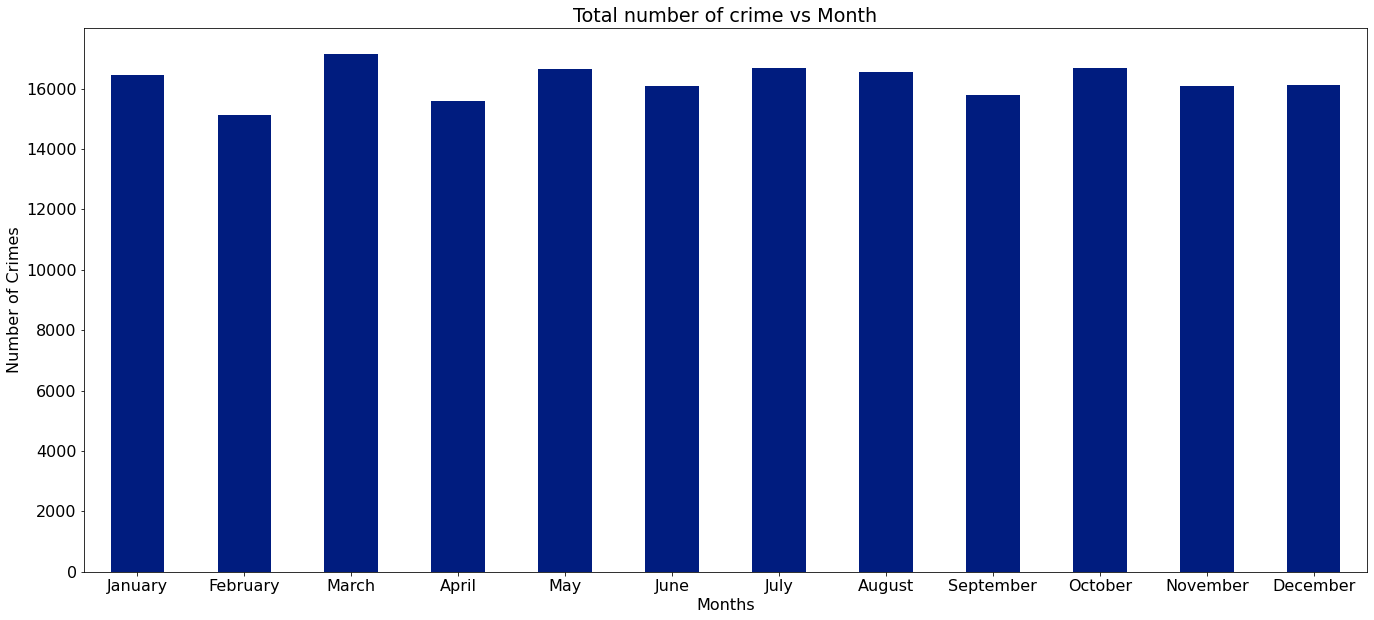

In [33]:
#Take a look at all the crime types
train2['month'] = pd.Categorical(train2['month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                                                            'September','October', 'November', 'December'])
#overall_mean = df.groupby('month').crime_type.value_counts()
train2.groupby('month').crime_type.count().plot.bar()
plt.title("Total number of crime vs Month")
plt.xlabel("Months")
plt.ylabel("Number of Crimes")
plt.tick_params('x', rotation=360)
#plt.axhline(overall_mean,color="r")
None

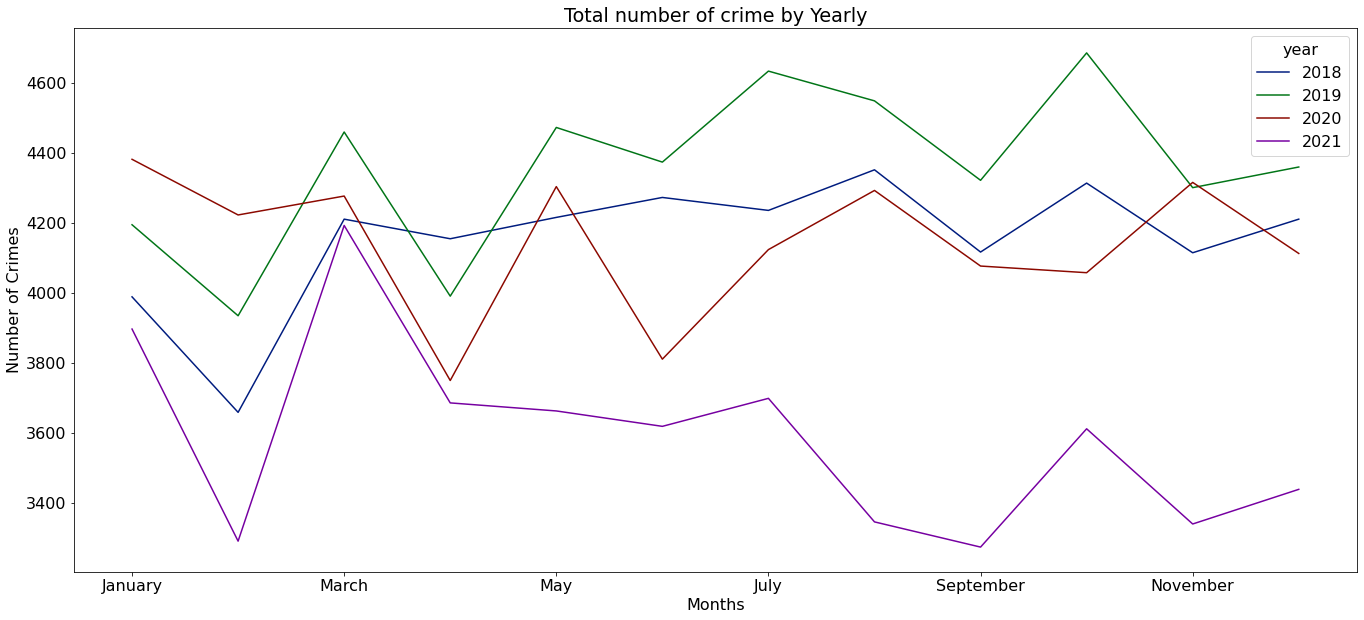

In [107]:
train2.groupby(['year', 'month']).cleared.count().unstack(0).plot.line()
plt.title("Total number of crime by Yearly")
plt.xlabel("Months")
plt.ylabel("Number of Crimes")
plt.tick_params('x', rotation=360)
#plt.axhline(overall_mean,color="r")
None

#### Take away 
- From the visuals, we can see that Friday (2019) has higest, all the months have almost the same number of crime and year of 2019. But still need to take a look deeper into which weekday of the year has the higest number.

In [35]:
train2 ['report_hour'] = train2.index.hour

In [36]:
train2 = train2.astype({'report_hour':int}, errors='raise')

In [37]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 194915 entries, 2018-01-01 00:00:00 to 2021-12-31 23:50:00
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   crime_type        194915 non-null  object         
 1   family_violence   194915 non-null  object         
 2   occurrence_date   194915 non-null  datetime64[ns] 
 3   report_time       194915 non-null  datetime64[ns] 
 4   report_date       194915 non-null  datetime64[ns] 
 5   location_type     194915 non-null  object         
 6   address           194915 non-null  object         
 7   zip_code          194915 non-null  float64        
 8   council_district  194915 non-null  float64        
 9   sector            194915 non-null  object         
 10  district          194915 non-null  object         
 11  latitude          194915 non-null  float64        
 12  longitude         194915 non-null  float64        
 13  clearance_

In [38]:
train2.report_hour.min

<bound method NDFrame._add_numeric_operations.<locals>.min of occurrence_time
2018-01-01 00:00:00     0
2018-01-01 00:00:00     0
2018-01-01 00:00:00     0
2018-01-01 00:00:00     0
2018-01-01 00:00:00     0
                       ..
2021-12-31 23:00:00    23
2021-12-31 23:20:00    23
2021-12-31 23:21:00    23
2021-12-31 23:40:00    23
2021-12-31 23:50:00    23
Name: report_hour, Length: 194915, dtype: int64>

In [39]:
bins = [0, 4, 12, 17, 24]
labels = [ 'Early Morning', 'Morning', 'Afternoon', 'Evening']

In [112]:
def f(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Evening'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

In [113]:
train2['report_hour_bins1'] = train2['report_hour'].apply(f)

In [114]:
train2 ['report_hour_bins'] = pd.cut(train2['report_hour'], bins = bins, labels = labels, right = False)
                                                    

In [115]:
train2.sample(10)

,crime_type,family_violence,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,...,clearance_date,cleared,time_to_report,month,weekdays,year,report_hour,report_hour_bins,clear_only,report_hour_bins1
occurrence_time,,,,,,,,,,,,,,,,,,,,,
2020-06-24 21:30:00,VIOL OF PROTECTIVE ORDER,N,2020-06-24,2020-06-24 22:07:00,2020-06-24,RESIDENCE / HOME,3508 RED RIVER ST,78705.0,9.0,BA,...,2020-06-25,True,0 days 00:37:00,June,Wednesday,2020,21,Evening,True,Night
2021-07-30 10:33:00,PROTECTIVE ORDER,N,2021-07-30,2021-07-30 10:33:00,2021-07-30,RESIDENCE / HOME,411 W ST ELMO RD,78745.0,3.0,DA,...,2021-07-30,False,0 days 00:00:00,July,Friday,2021,10,Morning,False,Morning
2018-12-30 04:30:00,RUNAWAY CHILD,N,2018-12-30,2018-12-30 13:15:00,2018-12-30,RESIDENCE / HOME,1500 E PARMER LN,78753.0,7.0,ED,...,2019-01-04,False,0 days 08:45:00,December,Sunday,2018,4,Morning,False,Late Night
2021-03-12 19:41:00,ONLINE SOLICITATION OF A MINOR,N,2021-03-12,2021-03-12 19:41:00,2021-03-12,HOTEL / MOTEL / ETC.,3121 PALM WAY,78758.0,7.0,AD,...,2022-05-28,False,0 days 00:00:00,March,Friday,2021,19,Evening,False,Evening
2021-10-04 14:15:00,IDENTITY THEFT,N,2021-10-04,2021-10-14 08:21:00,2021-10-14,OTHER / UNKNOWN,1520 RUTHERFORD LN,78754.0,1.0,ED,...,2021-10-14,False,9 days 18:06:00,October,Monday,2021,14,Afternoon,False,Noon
2018-10-05 08:00:00,FRAUD - OTHER,N,2018-10-05,2018-10-15 10:26:00,2018-10-15,RESIDENCE / HOME,11125 ZIMMERMAN LN,78726.0,6.0,AD,...,2018-10-16,False,10 days 02:26:00,October,Friday,2018,8,Morning,False,Early Morning
2018-06-16 00:42:00,DISTURBANCE - OTHER,N,2018-06-16,2018-06-16 00:42:00,2018-06-16,BAR / NIGHTCLUB,601 E BEN WHITE BLVD SVRD EB,78745.0,3.0,DA,...,2018-06-25,False,0 days 00:00:00,June,Saturday,2018,0,Early Morning,False,Late Night
2018-01-31 15:36:00,ASSAULT BY CONTACT,N,2018-01-31,2018-01-31 15:36:00,2018-01-31,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,LAKELINE BLVD / N US 183 HWY SVRD SB,78613.0,6.0,88,...,2018-02-17,True,0 days 00:00:00,January,Wednesday,2018,15,Afternoon,True,Noon
2020-05-13 20:00:00,THEFT,N,2020-05-13,2020-05-13 21:22:00,2020-05-13,RESTAURANT,1201 BARBARA JORDAN BLVD,78723.0,9.0,BA,...,2020-05-14,False,0 days 01:22:00,May,Wednesday,2020,20,Evening,False,Evening


In [116]:
train2.report_hour_bins.value_counts()

Evening          75020
Afternoon        49054
Morning          38849
Early Morning    31992
Name: report_hour_bins, dtype: int64

<AxesSubplot:xlabel='weekdays,clearance_status'>

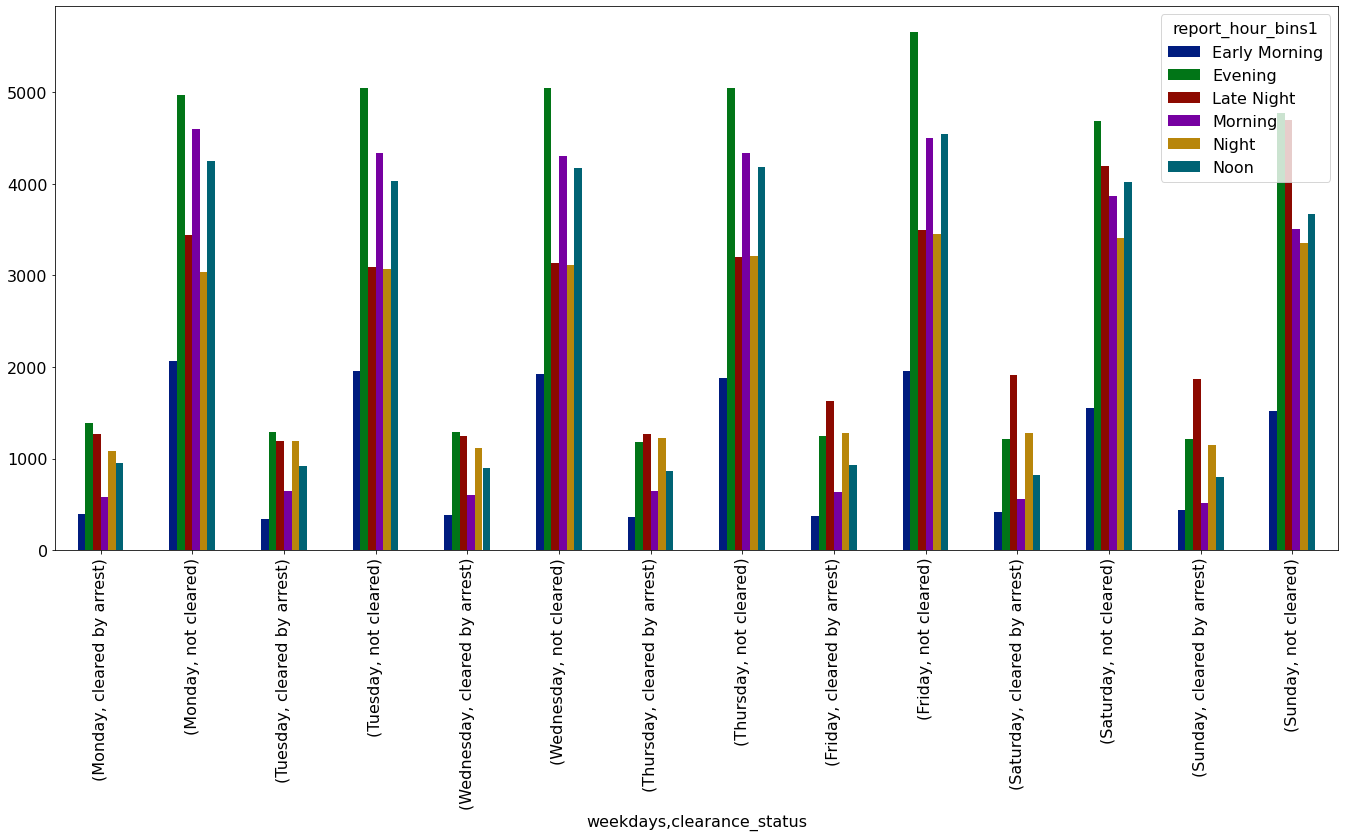

In [125]:
#Quick visual
train2.groupby(['report_hour_bins1','weekdays','clearance_status']).crime_type.count().unstack(0).plot.bar()

In [44]:
#Note: During the evening time there is more crime compare to early morning. But which crime is more like to happen at that hour?

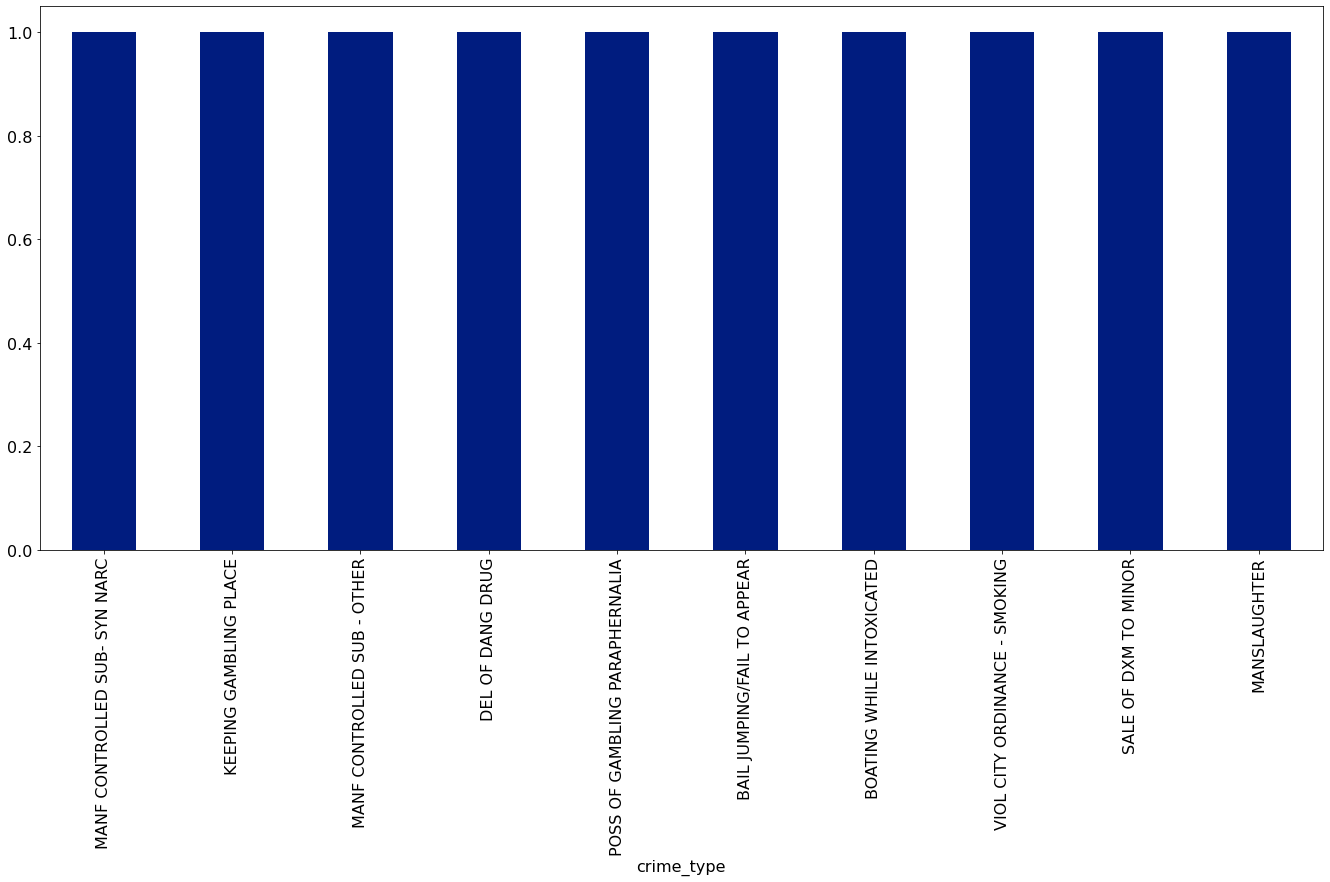

In [45]:
#Look at the top 10 crime types that get cleared
train2.groupby(['crime_type']).cleared.mean().sort_values(ascending = False).head(10).plot.bar();

In [97]:
train2.cleared.mean()

0.20814714106148835

<AxesSubplot:xlabel='year'>

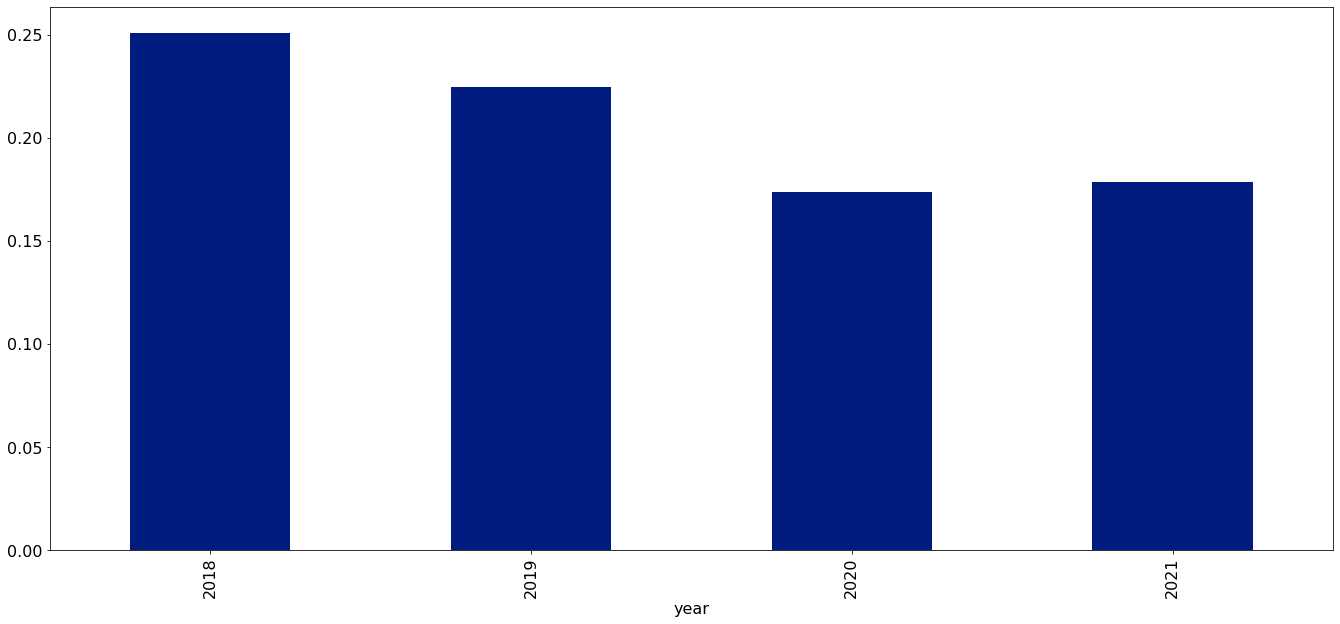

In [98]:
train2.groupby(['year']).cleared.mean().plot.bar()